# Diffusion Example Notebook

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

## Data - 2D Moons

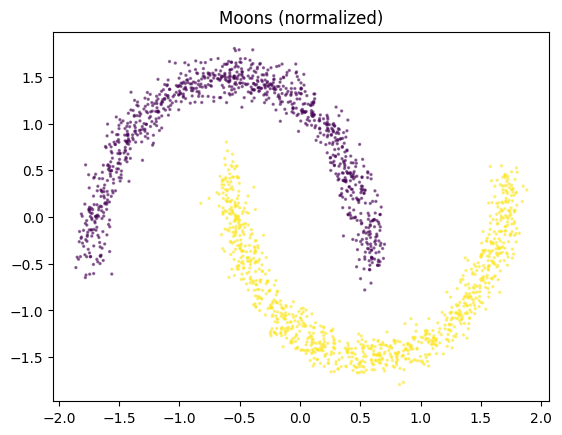

In [2]:
N = 20_000
X, y = make_moons(n_samples=N, noise=0.06)
X = X.astype(np.float32)
X = (X - X.mean(0)) / X.std(0)  # normalize to ~unit variance
data = torch.from_numpy(X).to(device)
labels = torch.from_numpy(y).to(device, dtype=torch.long)

# simple gaussian prior sampler
def sample_prior(n):
    return torch.randn(n, 2, device=device)

# quick scatter to see data
plt.figure()
plt.scatter(X[:2000,0], X[:2000,1], s=2, alpha=0.5, c=y[:2000])
plt.title("Moons (normalized)")
plt.show()

## Model

In [3]:
# Fourier time embedding + FiLM-conditioned MLP vector field

class FourierTimeEmbedding(nn.Module):
    """
    Positional/Fourier embedding for scalar t in [0, 1].
    Produces [sin(2π f_k t), cos(2π f_k t)] over K frequencies (log-spaced).
    Output dim = 2*K.
    """
    def __init__(self, num_frequencies: int = 16, f_min: float = 1.0, f_max: float = 256.0):
        super().__init__()
        # Log-spaced frequencies between f_min and f_max
        freqs = torch.logspace(math.log10(f_min), math.log10(f_max), steps=num_frequencies)
        self.register_buffer("freqs", freqs, persistent=False)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        # t: (N,) or (N,1), assume in [0,1]
        t = t.view(-1, 1)  # (N,1)
        ang = 2 * math.pi * t * self.freqs.view(1, -1)  # (N, K)
        return torch.cat([torch.sin(ang), torch.cos(ang)], dim=-1)  # (N, 2K)


class FiLMBlock(nn.Module):
    """
    One MLP block with FiLM modulation on hidden activations.
    h -> Linear -> SiLU -> FiLM(γ, β from t) -> h
    """
    def __init__(self, in_dim: int, out_dim: int, t_dim: int):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.act = nn.ReLU()
        # Produce γ and β from time embedding
        self.gamma_beta = nn.Linear(t_dim, 2 * out_dim)

        # Initialize FiLM so the network starts close to identity modulation: γ≈1, β≈0
        nn.init.zeros_(self.gamma_beta.weight)
        nn.init.zeros_(self.gamma_beta.bias)

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor) -> torch.Tensor:
        h = self.fc(x)
        h = self.act(h)
        gb = self.gamma_beta(t_embed)            # (N, 2*H)
        gamma, beta = gb.chunk(2, dim=-1)        # (N, H), (N, H)
        h = (1 + gamma) * h + beta               # FiLM modulation
        return h


class FiLMVectorField(nn.Module):
    """
    v_theta(x, t) with:
      - Fourier time embedding (sin/cos at log-spaced frequencies)
      - FiLM conditioning per block
      - Residual skip in the middle for stability (optional)
    """
    def __init__(self, dim: int = 2, hidden: int = 128,
                 num_frequencies: int = 16, f_min: float = 1.0, f_max: float = 256.0, num_classes: int = 2, label_emb_dim: int = 16):
        super().__init__()
        self.time_enc = FourierTimeEmbedding(num_frequencies, f_min, f_max)
        self.label_emb = nn.Embedding(num_classes, label_emb_dim)
        cond_dim = 2 * num_frequencies + label_emb_dim

        # Input layer (here we use x only)
        self.inp = nn.Linear(dim, hidden)

        # Two FiLM blocks
        self.block1 = FiLMBlock(hidden, hidden, cond_dim)
        self.block2 = FiLMBlock(hidden, hidden, cond_dim)

        # Optional residual projection for stability
        self.res_proj = nn.Linear(hidden, hidden)

        # Output head to vector field dimension
        self.out = nn.Linear(hidden, dim)

    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # x: (N, dim), t: (N,)
        t_embed = self.time_enc(t)          # (N, cond_dim)
        label_embed = self.label_emb(y)    # (N, label_emb_dim)
        t_embed = torch.cat([t_embed, label_embed], dim=-1)  # (N, cond_dim)
        h = self.inp(x)                     # (N, H)
        h = self.block1(h, t_embed)         # FiLM
        h_res = h
        h = self.block2(h, t_embed)         # FiLM
        h = h + self.res_proj(h_res)        # residual skip
        v = self.out(h)                     # (N, dim)
        return v


model = FiLMVectorField(dim=2, hidden=128, num_frequencies=16, f_min=1.0, f_max=256.0).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

## Training Loop - Denoising Diffusion Probabilistic Models

$$\mathcal{L}_{\mathrm{DDPM}}(\theta)
= \mathbb{E}_{t \sim \mathrm{Unif},\, z \sim p_{\mathrm{data}},\, \epsilon \sim \mathcal{N}(0, I_d)}
\left[ \left\| \epsilon_t^{\theta}(\alpha_t z + \beta_t \epsilon) - \epsilon \right\|^2 \right]$$

step 200: loss 0.6644
step 400: loss 0.6449
step 600: loss 0.6708
step 800: loss 0.6829
step 1000: loss 0.6663
step 1200: loss 0.6429
step 1400: loss 0.6582
step 1600: loss 0.6561
step 1800: loss 0.6565
step 2000: loss 0.6463
step 2200: loss 0.6688
step 2400: loss 0.6689
step 2600: loss 0.6456
step 2800: loss 0.6542
step 3000: loss 0.6886


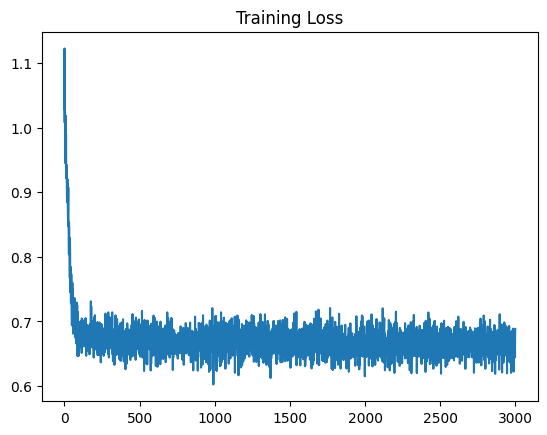

In [4]:
T = 10 # number of diffusion steps
beta_start, beta_end = 1e-4, 2e-2

def make_linear_beta_schedule(T, beta_start, beta_end, device):
    betas = torch.linspace(beta_start, beta_end, T, device=device)           # (T,)
    alphas = 1.0 - betas                                                      # (T,)
    abar = torch.cumprod(alphas, dim=0)                                     # (T,)  \bar{alpha}_t
    return betas, alphas, abar

betas, alphas, alpha_bar = make_linear_beta_schedule(T, beta_start, beta_end, device)


def batch(n: int = 2048) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Denoising diffusion training batch.
    returns:
        xt: (n, 2) tensor of noisy data
        t: (n,) tensor of time steps
        target_noise: (n, 2) tensor of target noise
        y0: (n,) tensor of labels
    """
    idx = torch.randint(0, data.shape[0], (n,), device=device)
    x0 = data[idx] # Sample n points from data
    y0 = labels[idx]
    gaussian_noise = torch.randn(n, 2, device=device)
    k = torch.randint(0, T, (n,), device=device) # discrete step indices
    abar_k = alpha_bar[k] # (n,)
    sqrt_abar   = torch.sqrt(abar_k).unsqueeze(1) # (n,1)
    sqrt_one_ma = torch.sqrt(1.0 - abar_k).unsqueeze(1) # (n,1)

    xt = sqrt_abar * x0 + sqrt_one_ma * gaussian_noise
    t  = (k.float() + 1) / T # normalize to (0,1]; use k/T if you prefer [0,1)

    return xt, t, gaussian_noise, y0  # target is ε

model.train()
losses = []
steps = 3_000
for step in range(1, steps+1):
    xt, t, target_v, y0 = batch()
    pred_v = model(xt, t, y0)
    loss = F.mse_loss(pred_v, target_v)
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()
    losses.append(loss.item())
    if step % 200 == 0:
        print(f"step {step}: loss {loss.item():.4f}")

plt.figure()
plt.plot(losses)
plt.title("Training Loss")
plt.show()

## Sampling by ODE

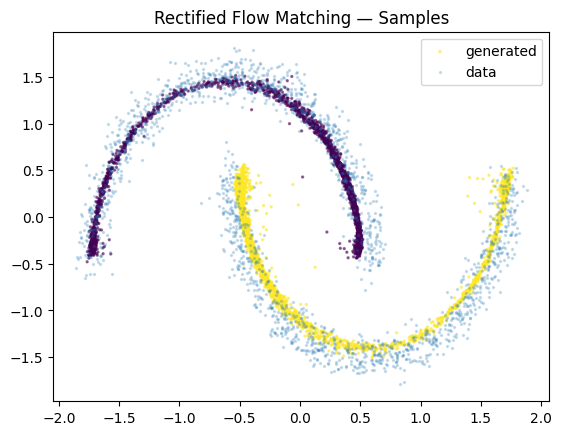

In [10]:
@torch.no_grad()
def sample(n=10_000, steps=200, labels=None, num_classes=2):
    if labels is None:
        labels = torch.randint(0, num_classes, (n,), device=device)
    x = sample_prior(n)
    ts = torch.linspace(1.0, 0.0, steps+1, device=device)  # include both ends
    for i in range(steps):
        t_i = ts[i].repeat(n)
        v = model(x, t_i, labels)
        dt = (ts[i+1] - ts[i])  # negative
        x = x + v * dt
    return x, labels

gen, labels = sample(5000, steps=1000)
gen = gen.detach().cpu().numpy()
labels = labels.cpu().numpy()
plt.figure()
plt.scatter(gen[:,0], gen[:,1], s=2, alpha=0.5, label='generated', c=labels)
plt.scatter(X[:2000,0], X[:2000,1], s=2, alpha=0.2, label='data')
plt.legend() 
plt.title("Rectified Flow Matching — Samples")
plt.show()